## Introduction:
The objective of this project is to navigate a Thymio robot to its goal, while taking the optimised path between fixed obstacles and avoiding mobile obstacles.

This is done by taking a picture of the map with fixed obstacles, the starting point and the goal. The coordinates of these are then extracted and an optimised path is calculated using cell decomposition and the Breadth-First Search algorithm. The path created is used to navigate the Thymio to its goal, while avoiding mobile obstacles which can be added after the creation of the map. The localisation of the Thymio is done using a particle filter based on the odometry of the Thymio and tracking done by the camera. 

## Assumptions made
In this project, several assumptions have been made to ensure good operation: 
1. The map is defined by the angle of view of the camera.
2. The map is white.
3. The only colors allowed on the map are: <span style="color:red">red</span>, <span style="color:blue">blue</span> (for Thymio detection), <span style="color:yellow">yellow</span> (for the goal) and <span style="color:black">black</span> (for fixed obstacles detection).
4. Fixed obstacles are flat, black and rectangular.
5. The goal and Thymio position indicators are circular, flat and coloured <span style="color:yellow">yellow</span> and  <span style="color:red">red</span>, <span style="color:blue">blue</span> respectively. These indicators are smaller than the fixed obstacles.
6. The distance between two fixed obstacles as well as the distance between a fixed obstacle and the map boundary need to be larger than the Thymio.
7. Mobile obstacles are not present during map analysis.
8. Mobile obstacles are flat black rings with a diameter bigger than 15 cm.
9. The distance between fixed and mobile obstacles is larger than the size of the thymio, i.e. 14cm.
10. The distance between two mobile obstacles is larger than the size of the thymio, i.e. 14cm.
11. It's forbidden to obstruct the camera during map analysis. 


## Import:
<p><p>

In [65]:
import os
import sys
import time
import serial
##############
import math
import random
import statistics
##############################################
import scipy as scipy
import scipy.stats
import numpy as np
np.set_printoptions(threshold=3)
np.set_printoptions(suppress=True)
import cv2
%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

from helpers.graph import *
from helpers.geometry import *;

%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook

###########################################
# Adding the src folder in the current directory as it contains the script
# with the Thymio class
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from Thymio import Thymio

print(sys.executable)

C:\Users\utilisateur\Anaconda3\python.exe


## Connecting to Thymio:
<p><p>

In [174]:
th = Thymio.serial(port="\\.\COM7", refreshing_rate=0.1) #7 pour TP427

## Map analysis and pathfinding:
<p><p>
    
For pathfinding, we model the problem with a graph, on which we apply a Breadth-First Search algorithm. The graph modelisation is a good idea in this case because this type of problem creates hollow graphs. This method creates simple paths composed of a list of coordinates. 

We first need to take a picture of the map with fixed obstacles, the goal and the starting position (corresponding to the Thymio).

In [177]:
cam = cv2.VideoCapture(1) #0 pour webcam, 1 pour external camera

cv2.namedWindow("test")

img_counter = 0

stopCriteria = True

while stopCriteria:
    ret, frame_single = cam.read()
    cv2.imshow("test", frame_single)
    if not ret:
        break
    k = cv2.waitKey(1)
    
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        stopCriteria = False
    elif k%256 == 32:
        # SPACE pressed
        img_name = "Set_Up2.PNG".format(img_counter)
        cv2.imwrite(img_name, frame_single)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()
cv2.destroyAllWindows()

Set_Up2.PNG written!
Escape hit, closing...


After filtering the high-frequency noise by blurring the gray-version of our image, we convert it into a black and white one.

<IPython.core.display.Javascript object>


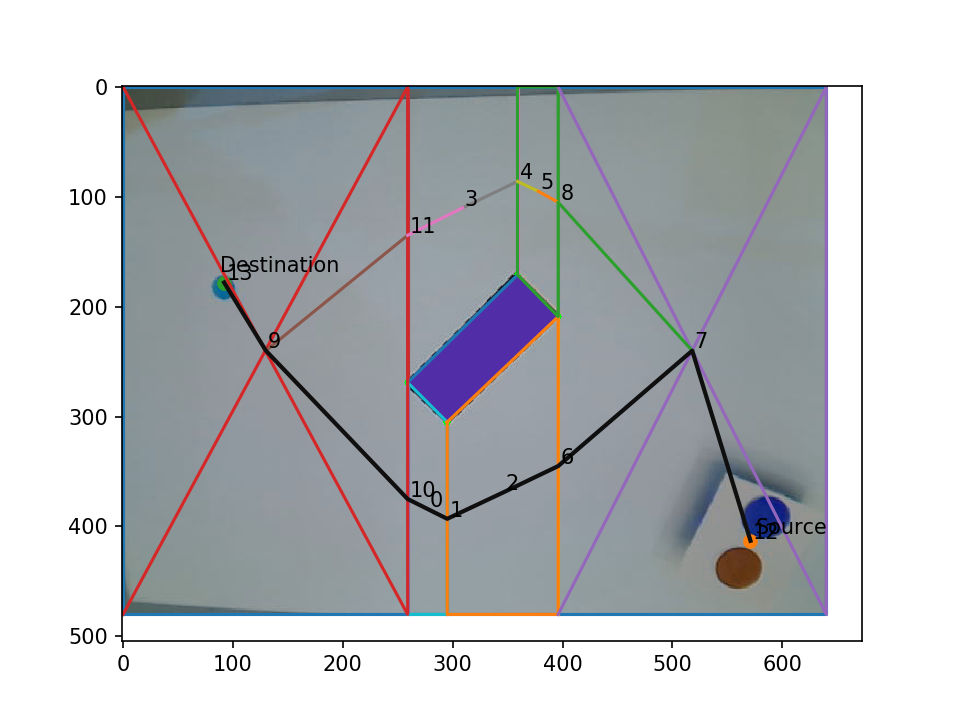

In [190]:
img = cv2.imread('Set_Up2.PNG') # white background + black objects
grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(grayImg, (5, 5), 0)
(thres, bw_img) = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
height, width = img.shape[:2]
map_boundary = [[0,height],[width,height],[width,0],[0,0]]

plt.imshow(grayImg, 'gray')

## Fixed obstacles detection

We then invert the pixels' colors to have white obstacles against a black background (as required by OpenCV functions). We only detect obstacles that are "large enough". This minimal area is defined as to exclude the small color dots (used for the starting point and goal detection). We get polygons with too many sides (due to the tiny irregularities detected by the camera). We smooth the contour in order to obtain four-sided obstacles. We then convert the array of arrays given by the « approxPolyDP » function into a list of lists for our vertical cell decomposition algorithm.

In [191]:
wb_img = np.invert(bw_img) # black bachground and white objects
contours, hierarchy = cv2.findContours(wb_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

all_obstacles = []
obstacle_sides = 4 # we consider that all our fixed obstacles have 4 sides

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area>2500:
        
        # smooth the contour of the obstacle
        epsilon = 0.02*cv2.arcLength(cnt, True)
        smooth_cnt = cv2.approxPolyDP(cnt, epsilon, True)
        cv2.drawContours(img, smooth_cnt, -1, (0,255,0), 5)
        
        obstacle = []
        for i in range(obstacle_sides):
            obstacle.append([smooth_cnt[i][0][0],smooth_cnt[i][0][1]])
        
        all_obstacles.append(obstacle)

plt.imshow(img)



In [192]:
def compute_tracking_params(x1,y1,x2,y2):
    #compute position and orientation

    position = [(x1+x2)/2,(y1+y2)/2]
    
    if x1 != x2:
        alpha = np.pi/2 + np.cos((y1-y2)/(x1-x2))
    
    return (position,alpha)

In [193]:
def detection_color_start(frame,x_blue,y_blue,x_red,y_red):

    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Red color
    low_red = np.array([0, 120, 150])  #[161, 155, 84] old
    high_red = np.array([4, 255, 255]) #[179, 255, 255] old
    red_mask = cv2.inRange(hsv_frame, low_red, high_red)
    red = cv2.bitwise_and(frame, frame, mask=red_mask)
    
    # Blue color
    low_blue = np.array([104, 178, 70])
    high_blue = np.array([130, 240, 124])
    blue_mask = cv2.inRange(hsv_frame, low_blue, high_blue)
    blue = cv2.bitwise_and(frame, frame, mask=blue_mask)
    
    ## final mask
    mask_t = cv2.bitwise_or(red_mask, blue_mask)
    target = cv2.bitwise_and(frame,frame, mask=mask_t)

    #Find centers
    
    #Blue
    points_blue = cv2.findNonZero(blue_mask)
    if points_blue is not None:
        avg_blue = np.mean(points_blue, axis=0)
        x_blue = int(avg_blue[0][0])
        y_blue = int(avg_blue[0][1])
          
    #Red
    points_red = cv2.findNonZero(red_mask)
    if points_red is not None:
        avg_red = np.mean(points_red, axis=0)
        x_red = int(avg_red[0][0])
        y_red = int(avg_red[0][1])
    
    #Compute the position and orientation of the thymio
    [position,alpha] = compute_tracking_params(x_blue,y_blue,x_red,y_red)
        
    return (position,alpha)

In [194]:
def detection_color_goal(frame,x_yellow,y_yellow):

    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Yellow color
    low_yellow = np.array([15, 117, 72])  # green = [25, 52, 72] #yellow = [15, 117, 72]
    high_yellow = np.array([20, 255, 200])   # green = [102, 255, 255] #yellow=[20, 255, 200]
    yellow_mask = cv2.inRange(hsv_frame, low_yellow, high_yellow)
    yellow = cv2.bitwise_and(frame, frame, mask=yellow_mask)
    
    #Find center
    points_yellow = cv2.findNonZero(yellow_mask)
    if points_yellow is not None:
        avg_yellow = np.mean(points_yellow, axis=0)
        x_yellow = int(avg_yellow[0][0])
        y_yellow = int(avg_yellow[0][1])
        
    return (x_yellow,y_yellow)

## Start and goal detection

In [195]:
start,_ = detection_color_start(img,0,0,0,0)
start = [571,413]

goal_x,goal_y = detection_color_goal(img,0,0)
goal = [goal_x,goal_y]
goal = [92,178]

## Vertical cell decomposition and path planning

We chose the vertical cell decomposition approach as a fixed grid would have taken a lot of space in the memory.

We used code from [Github](https://github.com/topics/vertical-cell-decomposition) as a basis.

First, we had to **adapt the Github file to Python3**. For example, we replaced *xrange()* that no longer exists in Python 3 by *range()*.In addition, we converted the *min* variable to *Min* to avoid confusion with the *min()* function.

We then took the time to **understand how the code works**, i.e., in what **format** are stored the obstacles, start point, goal and boundary. The code we found on Github took a formatted file as an input and returned another formatted file as an output. We found a way to express the array of arrays of our obstacles identified using OpenCV as a list of lists with the correct syntax. In the same manner, we removed the code that generated the output code. Instead, we directly stored in the correct order the points (from *graph_vertices*) of the path our Thymio had to follow.

Another issue we tackled in order to use this code was dealing with a different **axis direction**. In OpenCV, the y-axis increases the lower you go. In the Github code, it's the opposite. Therefore, we switched the values of *y_limit_lower* and *y_limit_upper*. 

In [196]:
# Draw the obstacles and point the source and the destination----------------------------------------------
def draw_problem():
    bnd_x = [i.x for i in boundary];
    bnd_x.append(boundary[0].x);
    bnd_y = [i.y for i in boundary];
    bnd_y.append(boundary[0].y);
    poly_x = [];
    poly_y = []

    # Draw the boundary
    plt.plot(bnd_x, bnd_y);
    
    for index, i in enumerate(obstacles):
        poly_x.append([p[0] for p in i]);
        poly_y.append([p[1] for p in i]);
    
        plt.fill( poly_x[index], poly_y[index], color="#512DA8");
    
    plt.plot(source.x, source.y, marker="o");
    plt.plot(dest.x, dest.y, marker="o");
    plt.annotate('Source', xy=(source.x, source.y), xytext=(source.x+5, source.y-6) );
    plt.annotate('Destination', xy=(dest.x, dest.y), xytext=(dest.x-4, dest.y-10) );

In [197]:
# Extract vertices----------------------------------------------
temp = map_boundary;
boundary = [point(i[0], i[1]) for i in temp];

# Extract source and dest
source = point(start[0], start[1]);
dest = point(goal[0], goal[1]);

# Extract obstacles
obstacles = all_obstacles;

#sort by x-values
sorted_vertices = [];
for index,i in enumerate(obstacles):
    for j in i:
        j.append(index);
        sorted_vertices.append(j);
sorted_vertices.sort(key=lambda x: x[0]);

# Draw the problem
draw_problem();

new_sorted_vertices = [];

for i in sorted_vertices:
    temp = point(i[0], i[1], i[2]);
    new_sorted_vertices.append(temp);

new_obstacles = [];
for index, i in enumerate(obstacles):
    temp_obs = [];
    for j in i:
        temp = point(j[0], j[1], index);
        temp_obs.append(temp);
    new_obstacles.append(temp_obs); 

#-----------------------------------------------------------
# Find vertical lines
open_line_segments = [];

#y_limit_lower = boundary[0].y;
#y_limit_upper = boundary[2].y;

y_limit_lower = boundary[2].y;
y_limit_upper = boundary[0].y;

for pt in new_sorted_vertices:
    curr_line_segment = [ point(pt.x, y_limit_lower), point(pt.x, y_limit_upper) ]; 
    lower_obs_pt = curr_line_segment[0];
    upper_obs_pt = curr_line_segment[1];
    upper_gone = False;
    lower_gone = False;
    break_now = False;

    # Find intersection points with the vertical proposed lines. the intersection function returns false if segments are same, so no need to worry about same segment checking
    for index,obs in enumerate(new_obstacles):
        # Add the first point again for the last line segment of a polygon.
        
        obs.append( obs[0] );
        for vertex_index in range(len(obs)-1 ):
            res = segment_intersection( curr_line_segment[0], curr_line_segment[1], obs[vertex_index],  obs[vertex_index+1]);
            if (res!=-1):
                if ( index == pt.obstacle ):
                    if pt.equals( res ) == False:
                        if ( res.y > pt.y ):
                            upper_gone = True;
                        elif ( res.y < pt.y ):
                            lower_gone = True;  
                else:   
                    if pt.equals( res ) == False:
                        if ( upper_gone is False ):
                            if ( (res.y > pt.y) and res.y < (upper_obs_pt.y) ):
                                upper_obs_pt = res;
                        if ( lower_gone is False ):
                            if ( (res.y < pt.y) and (res.y > lower_obs_pt.y) ):
                                lower_obs_pt = res;
            if( upper_gone is True and lower_gone is True ):
                break_now = True;

        #No need to check for current point anymore...completely blocked
        if(break_now is True):
            break;      

    # Draw the vertical cell lines
    if(lower_gone is False):
        plt.plot( [lower_obs_pt.x, pt.x],  [lower_obs_pt.y, pt.y] );
        
    if(upper_gone is False):
        plt.plot( [pt.x, upper_obs_pt.x],  [pt.y, upper_obs_pt.y] );

    # Add to the global segment list
    if (lower_gone and upper_gone):
        open_line_segments.append([None, None]);
    elif (lower_gone):
        open_line_segments.append([None, upper_obs_pt]);
    elif (upper_gone):
        open_line_segments.append([lower_obs_pt, None]);
    else:
        open_line_segments.append([lower_obs_pt, upper_obs_pt]);


#------------------------------------------------------
# Find Polygon cells naiively. Will improve next. 
cells = [];

for index1 in range(len(open_line_segments) ):
    curr_segment = open_line_segments[index1];
    curr_vertex = new_sorted_vertices[index1];
    break_now = False;
    done = [False, False, True];
    if( curr_segment[0] is None ):
        done[0] = True; 
    if( curr_segment[1] is None ):
        done[1] = True; 
    if( curr_segment[1] is None and open_line_segments[index1][0] is None):
        done[2] = False;    

    for index2 in range(index1+1,  len(open_line_segments) ):
        next_segment = open_line_segments[index2];
        next_vertex = new_sorted_vertices[index2];          
        
        double_index1 = -2;
        double_index2 = -2;
        lines_to_check = [];
        trapezoids = [];
        double_check = False;

        if ( next_segment[0] is not None and next_segment[1] is not None ):
            double_check = True;

        if( done[0] is False ):
            if( double_check ):
                double_index1 = len(lines_to_check);
                lines_to_check.append( [centroid([curr_segment[0], curr_vertex]), centroid([next_segment[0], next_vertex]), 0]);
                lines_to_check.append( [centroid([curr_segment[0], curr_vertex]), centroid([next_segment[1], next_vertex]), 0]);
                trapezoids.append([ curr_segment[0], next_segment[0], next_vertex, curr_vertex ]);
                trapezoids.append([ curr_segment[0], next_vertex, next_segment[1], curr_vertex ]);
            elif ( next_segment[0] is not None ):
                lines_to_check.append( [centroid([curr_segment[0], curr_vertex]), centroid([next_segment[0], next_vertex]), 0]);
                trapezoids.append([ curr_segment[0], next_segment[0], next_vertex, curr_vertex ]);
            elif( next_segment[1] is not None ):
                lines_to_check.append( [centroid([curr_segment[0], curr_vertex]), centroid([next_segment[1], next_vertex]), 0]);
                trapezoids.append([ curr_segment[0], next_vertex, next_segment[1], curr_vertex ]);
            else:
                lines_to_check.append( [centroid([curr_segment[0], curr_vertex]), next_vertex, 0]);
                trapezoids.append([ curr_segment[0], next_vertex, curr_vertex ]);

        if( done[1] is False ):
            if( double_check ):
                double_index2 = len(lines_to_check);
                lines_to_check.append( [centroid([curr_segment[1], curr_vertex]), centroid([next_segment[0], next_vertex]), 1]);
                lines_to_check.append( [centroid([curr_segment[1], curr_vertex]), centroid([next_segment[1], next_vertex]), 1]);
                trapezoids.append([ curr_vertex, next_segment[0], next_vertex , point(curr_segment[1].x, curr_segment[1].y,curr_segment[1].obstacle, 34)]);
                trapezoids.append([ curr_vertex, next_vertex, next_segment[1], curr_segment[1] ]);
            elif ( next_segment[1] is not None ):
                lines_to_check.append( [centroid([curr_segment[1], curr_vertex]), centroid([next_segment[1], next_vertex]), 1]);
                trapezoids.append([ curr_vertex, next_vertex, next_segment[1], curr_segment[1] ]);
            elif( next_segment[0] is not None ):
                lines_to_check.append( [centroid([curr_segment[1], curr_vertex]), centroid([next_segment[0], next_vertex]), 1]);
                trapezoids.append([ curr_vertex, next_segment[0], next_vertex , curr_segment[1] ]);
            else:
                lines_to_check.append( [centroid([curr_segment[1], curr_vertex]), next_vertex, 1]);
                trapezoids.append([ curr_vertex, next_vertex, curr_segment[1] ]);
        
        if( done[2] is False ):
            if(double_check):
                double_index = len(lines_to_check);
                lines_to_check.append( [curr_vertex, centroid([next_segment[0], next_vertex]), 2]);
                trapezoids.append([ curr_vertex,next_segment[0], next_vertex ]);
                lines_to_check.append( [curr_vertex, centroid([next_segment[1], next_vertex]), 2]);
                trapezoids.append([ curr_vertex, next_vertex, next_segment[1] ]);
            elif ( next_segment[0] is not None ):
                lines_to_check.append( [curr_vertex, centroid([next_segment[0], next_vertex]), 2]);
                trapezoids.append([ curr_vertex,next_segment[0], next_vertex ]);
            elif( next_segment[1] is not None ):
                lines_to_check.append( [curr_vertex, centroid([next_segment[1], next_vertex]), 2]);
                trapezoids.append([ curr_vertex, next_vertex, next_segment[1] ]);
            # Will this ever occur though??
            else:
                lines_to_check.append( [curr_vertex, next_vertex, 2]);
                trapezoids.append([curr_vertex, next_vertex]);

        temp_to_remove = [];
        for index5,q in enumerate(lines_to_check): 
            ok = [True, True, True];
            for index3,obs in enumerate(new_obstacles):
                # Add the last line to make closed polygon
                obs.append( obs[0] );
                for index4 in range(len(obs)-1):
                    if (segment_intersection( q[0], q[1],  obs[index4],  obs[index4+1]) != -1):
                        ok[q[2]] = False;
                        if(index5 not in temp_to_remove):
                            temp_to_remove.append(index5);
                        

            if (  ok[q[2]] is True ):
                done[q[2]] = True;

        for i in range(len(lines_to_check)):
            if i not in temp_to_remove:
                cells.append(trapezoids[i]);
        
        if( done[0] == True and done[1] == True and done[2] == True ):
            break;

to_draw =[];
for i in cells:
    i.append(i[0]);
    to_draw.append(i);


#-------------------------------------------------------
# Merge overlapping Polygons
quad_cells = [i for i in cells if len(i)>3];
tri_cells = [i for i in cells if len(i)==3];
others = [i for i in cells if len(i)<3];
quads_to_remove = [];
quads_to_add = [];

quads_to_remove = [];
quads_to_add = [];
for index_cell in range(len(quad_cells)):
    for index_cell2,cell in enumerate(quad_cells):
        if(index_cell != index_cell2):
            if(quad_cells[index_cell][0].x == cell[0].x and quad_cells[index_cell][1].x == cell[1].x):
                    temp1 = list(quad_cells[index_cell]);
                    temp1.append(temp1[0]);
                    temp2 = list(cell);
                    temp2.append(temp2[0]);
                    area1 = polygon_area(temp1,4); area2 = polygon_area(temp2,4);
                    new_quad=[];
                    
                    new_quad.append( point(temp1[0].x, min(temp1[0].y, temp2[0].y)) );
                    new_quad.append( point(temp1[1].x, min(temp1[1].y, temp2[1].y)) );
                    new_quad.append( point(temp1[1].x, max(temp1[2].y, temp2[2].y)) );
                    new_quad.append( point(temp1[0].x, max(temp1[3].y, temp2[3].y)) );
                    new_quad.append( point(temp1[0].x, min(temp1[0].y, temp2[0].y)) );
                    area3 = polygon_area(new_quad, 4);
                    if( area1 + area2 >= area3):
                        #merge
                        quads_to_remove.append(index_cell);
                        quads_to_remove.append(index_cell2);
                        
                        quads_to_add.append(new_quad);

quads_to_remove = list(set(quads_to_remove));
for index in sorted(quads_to_remove, reverse=True):
    del quad_cells[index];

for i in quads_to_add:
    quad_cells.append(i);

# Remove duplicates
to_remove = [];
for index1 in range(len(quad_cells)):
    for index2 in range(index1+1, len(quad_cells)):
        duplicate = True;
        for k,m in zip(quad_cells[index1], quad_cells[index2]):
            if k.equals(m) is False:
                duplicate = False;
                break;
        if(duplicate is True):
            if index2 not in to_remove:
                to_remove.append(index2);       

for index in sorted(to_remove, reverse=True):
    del quad_cells[index];

# One more pass to remove extra quads generated because of cross - segments
quads_to_remove = [];
for index1 in range(len(quad_cells)):
    for index2 in range(len(quad_cells)):
        if(index1 != index2 and quad_cells[index1][0].x == quad_cells[index2][0].x and quad_cells[index1][1].x == quad_cells[index2][1].x):
            
            if( (quad_cells[index1][0].y<= quad_cells[index2][0].y) and  (quad_cells[index1][1].y<= quad_cells[index2][1].y)
                and (quad_cells[index1][2].y>= quad_cells[index2][2].y) and (quad_cells[index1][3].y >= quad_cells[index2][3].y)):          
                quads_to_remove.append(index2);


quads_to_remove = list(set(quads_to_remove) );
for index in sorted(quads_to_remove, reverse=True):
    del quad_cells[index];


#------------------------------------------------------
# Add boundary lines
if( boundary[0].x != new_sorted_vertices[0].x):
    quad_cells.append([boundary[0], point(new_sorted_vertices[0].x, y_limit_lower), point(new_sorted_vertices[0].x, y_limit_upper), boundary[3]]);
if( boundary[1].x != new_sorted_vertices[len(new_sorted_vertices)-1].x):
    quad_cells.append([point(new_sorted_vertices[len(new_sorted_vertices)-1].x ,y_limit_lower), boundary[1], boundary[2], point(new_sorted_vertices[len(new_sorted_vertices)-1].x, y_limit_upper) ]);

#-------------------------------------------------------
# Plot final cells
to_draw = quad_cells+tri_cells+others;
for i in to_draw:
    x = [j.x for j in i];
    y = [j.y for j in i];
    plt.plot(x, y);

#----------------------------------------------------------------------
# Get the graph
graph_vertices = [];
graph_edges = [];

for index1 in range(len(quad_cells)):
    same_boundary = [];
    for index2 in range(len(quad_cells)):
        if(index1 != index2):
            if( (quad_cells[index1][1].x == quad_cells[index2][0].x ) and ((quad_cells[index1][2].y in [quad_cells[index2][0].y, quad_cells[index2][3].y]) or (quad_cells[index1][1].y in [quad_cells[index2][0].y, quad_cells[index2][3].y]) ) ):
                same_boundary.append(index2);

    temp = quad_cells[index1][0:4];
    centroid_vertex = centroid(temp);
    place = centroid_vertex.find_point(graph_vertices)
    if( place == -1):
        graph_vertices.append(centroid_vertex);

    if(len(same_boundary)==1):
        temp_edge_middle = centroid([quad_cells[index1][1], quad_cells[index1][2]]);
        graph_vertices.append(temp_edge_middle);
        n = len(graph_vertices)-1;
        if(place != -1):
            graph_edges.append([place, n]);
        else:
            graph_edges.append([n-1, n]);
        temp = quad_cells[same_boundary[0]][0:4];
        curr_centroid_vertex = centroid(temp);
        place2 = curr_centroid_vertex.find_point(graph_vertices);
        if( place2 == -1 ):
            graph_vertices.append(curr_centroid_vertex);
            graph_edges.append([n, n+1]);
        else:
            graph_edges.append([n, place2]);

    elif(len(same_boundary)>1):
        n = len(graph_vertices)-1;
        if(place != -1):
            use = place;
        else:
            use = n;    
        for index, i in enumerate(same_boundary):
            temp = quad_cells[i][0:4];
            curr_centroid_vertex = centroid(temp);
            temp_edge_middle = centroid([quad_cells[i][0], quad_cells[i][3]]);
            graph_vertices.append(temp_edge_middle);
            pl1 =len(graph_vertices)-1;
            hmmm= curr_centroid_vertex.find_point(graph_vertices);
            if (hmmm == -1):
                graph_vertices.append(curr_centroid_vertex);
                pl2 =len(graph_vertices)-1;
            else:
                pl2 = hmmm; 
            graph_edges.append([use, pl1]);
            graph_edges.append([pl1, pl2]);     


# Add source and dest to graph
# Find the smallest distance vertex on graph and see if its clear to traverse
# Source------------------------------
min_ind = -1; Min = 9999999;
for index, i in enumerate(graph_vertices):
    if( check_obstruction(new_obstacles, [source, i]) is True ):
        dist = find_dist(i, source);
        if( dist < Min):
            Min = dist;
            min_ind = index;

graph_vertices.append(source);
m = len(graph_vertices)-1;
graph_edges.append([min_ind, m]);   

# Destination------------------------------------
min_ind = -1; Min = 9999999;
for index, i in enumerate(graph_vertices):
    if( check_obstruction(new_obstacles, [dest, i]) is True ):
        dist = find_dist(i, dest);
        if( dist < Min):
            Min = dist;
            min_ind = index;

graph_vertices.append(dest);
m = len(graph_vertices)-1;
graph_edges.append([min_ind, m]);

# Convert graph in adjacency list format
graph = [];
for j in range(len(graph_vertices)):
    graph.append([]);
    for i in graph_edges:
        if(i[0]==j):
            graph[j].append(i[1]);
        elif(i[1]==j):
            graph[j].append(i[0]);  

path = bfs(graph, len(graph_vertices)-2, len(graph_vertices)-1);

if(path is None):
    print("No path found. Sorry");
    sys.exit();
else:
    print("Path found.");

# Format output of cell decomposition function -----------------------
output = []
for index in path:
    output.append([graph_vertices[index].x,graph_vertices[index].y])

# Draw everything--------------
for index,i in enumerate(graph_vertices):
    plt.annotate(str(index), xy=(i.x, i.y), xytext=(i.x+2, i.y-2) );
    # plt.plot(i.x,i.y, marker="x");

for i in graph_edges:
    temp_x = [graph_vertices[i[0]].x, graph_vertices[i[1]].x];
    temp_y = [graph_vertices[i[0]].y, graph_vertices[i[1]].y];
    plt.plot(temp_x,temp_y);


# draw path
temp_x = [graph_vertices[i].x for i in path];
temp_y = [graph_vertices[i].y for i in path];
plt.plot(temp_x,temp_y, color="#0F0F0F", linewidth=2);  


plt.show();

Path found.


## Movement control functions:
<p> <p>

In [198]:
import random

## Class definition:
The class speed defines the object speed with two variables: the translation speed and the angular speed
This class also contains a function that converts the value returned by the sensors of the wheel to the translation and angular speed.

The class thymio represents the robot with the pose of the robot (coordinate x,y and the orientation), the coordinate of the next target and the list of all the targets.

In [199]:
class speed:
    def __init__(self):
        self.translation_speed = 0
        self.angular_speed = 0
        
    def set(self,speed_right_wheel, speed_left_wheel):
               
        if (speed_right_wheel>MAX_WHEEL_SPEED):
            speed_right = (((speed_right_wheel-2**16)*COEFF_SPEED)/COEFF_SPEED_MAX)/WHEEL_RADIUS # complement à deux car envoi que des int 
            speed_left = ((speed_left_wheel*COEFF_SPEED)/COEFF_SPEED_MAX)/WHEEL_RADIUS
        elif (speed_left_wheel>MAX_WHEEL_SPEED):
            speed_right = ((speed_right_wheel*COEFF_SPEED)/COEFF_SPEED_MAX)/WHEEL_RADIUS
            speed_left = (((speed_left_wheel-2**16)*COEFF_SPEED)/COEFF_SPEED_MAX)/WHEEL_RADIUS
        elif (speed_right_wheel>MAX_WHEEL_SPEED and speed_left_wheel>MAX_WHEEL_SPEED):
            speed_right = (((speed_right_wheel-2**16)*COEFF_SPEED)/COEFF_SPEED_MAX)/WHEEL_RADIUS
            speed_left = (((speed_left_wheel-2**16)*COEFF_SPEED)/COEFF_SPEED_MAX)/WHEEL_RADIUS
        else: 
            speed_right = ((speed_right_wheel*COEFF_SPEED)/COEFF_SPEED_MAX)/WHEEL_RADIUS
            speed_left = ((speed_left_wheel*COEFF_SPEED)/COEFF_SPEED_MAX)/WHEEL_RADIUS
        
        self.translation_speed = ((speed_right*WHEEL_RADIUS)+(speed_left*WHEEL_RADIUS))/2
        self.angular_speed = -((speed_right*WHEEL_RADIUS)-(speed_left*WHEEL_RADIUS))/(2*WHEEL_DISTANCE)
        
    def set_speed(self,v,w):
        self.translation_speed = v
        self.angular_speed = w
        
    def get(self):
        return self
    
class thymio:
    def __init__(self):
        self.x = 300 #random.random() * world_size  # initialise with random
        self.y = 300 #random.random() * world_size
        self.theta = math.pi/2 #(math.pi)/4
        
        self.translation_noise = 0.0
        self.orientation_noise = 0.0
        self.sensor_noise   = 0.0
               
        self.targets=[]
        
        self.x_target = 0
        self.y_target = 0
        self.state=NOT_ARRIVED
    
    def set(self, new_x, new_y, new_theta):
        if new_x < 0 or new_x >= WORLD_SIZE:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= WORLD_SIZE:
            raise ValueError('Y coordinate out of bound')
        if new_theta < 0 or new_theta >= 2*math.pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.theta = float(new_theta)
              
    def set_list_targets(self,new_list):
        self.targets=new_list
        self.x_target=self.targets[0][0]
        self.y_target=self.targets[0][1]
             
    def set_next_target(self):
        idx = self.targets.index([self.x_target,self.y_target])
        idx = idx+1
        if idx >= len(self.targets):
            self.state=ARRIVED
        else:
            self.x_target=self.targets[idx][0]
            self.y_target=self.targets[idx][1]
    
    def set_noise(self, new_translation_noise, new_orientation_noise, new_sensor_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.translation_noise = float(new_translation_noise);
        self.orientation_noise    = float(new_orientation_noise);
        self.sensor_noise   = float(new_sensor_noise);
      
    def sense(self,tracking_x,tracking_y):
        distance = math.sqrt((self.x - tracking_x) ** 2 + (self.y - tracking_y) ** 2)
        distance += random.gauss(0.0, self.sensor_noise)
        return distance
                
    def sense_angle(self,tracking_theta):
        diff = abs(self.theta-tracking_theta)
        return diff
     
    def move(self,all_speed,sampling_time):
        #move particles
        
        # turn, and add randomness to the turning command
        theta = self.theta + sampling_time*float(all_speed.angular_speed) + 0.5*random.gauss(0.0, self.orientation_noise)
        theta %=  2*math.pi
                     
        # move, and add randomness to the motion command
        dist = sampling_time*float(all_speed.translation_speed) + random.gauss(0.0, self.translation_noise)
        y = self.y + (math.cos(theta) * dist)
        x = self.x + (math.sin(theta) * dist)
        x %= WORLD_SIZE    # cyclic truncate
        y %= WORLD_SIZE       
        
        # set particle
        particle = thymio()
        particle.set(x, y, theta)
        particle.set_noise(self.translation_noise, self.orientation_noise, self.sensor_noise)
        
        return particle
    
    def Gaussian(self, mu, sigma, x):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        if sigma == 0:
            return 1
        else:
            return math.exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / math.sqrt(2.0 * math.pi * (sigma ** 2))
    
    def measurement_prob(self,dist):
        # calculates how likely a measurement should be
        prob = 1.0
        prob *= self.Gaussian(0,self.sensor_noise,dist)
        return prob
    
    def calculate_move_line(self,case):   
        #calculate line to target when sees obstacle
        self.bef_obs_x=self.x
        self.bef_obs_y=self.y
        
        if(case==FAR_TARGET):
            self.a=(self.y_target-self.y)/(self.x_target-self.x)
            self.b=self.y*self.x_target-self.y_target*self.y
        
        #obstacle on target->line of movement is the line between target and the target after
        elif(case==CLOSE_TARGET):
            x_target_old = self.x_target
            y_target_old = self.y_target
            self.set_next_target()
            
            self.a=(self.y_target-y_target_old)/(self.x_target-x_target_old)
            self.b=y_target_old*self.x_target-self.y_target*y_target_old


## Filter computation function:
<p> <p>
    
The implemented filter is the particle filter. Each particle represents a possible location of the robot. The denser a subregion of the state space is populated by the particles, the more likely it is that the true state falls into this region. This filter gives the most probable location and the location that have a very low probility.

The particle filter uses the odometry and the position given by the visual tracking.
Each particule moves according to the odometry given by the motor sensors of the thymio and a noise representing the imprecision of the sensors is added.

Then two cases occur,

-Fisrt case: we have no position given by the tracking then we only move the particle.

-Second case: the visual tracking returns the position of the thymio

In this case, we give to each particle a (gaussian) weight (between 0 and 1) depending on the distance between the particle and the value given by the tracking and on the orientation. 

The weight is given following a gaussian function with mean zero, a variance corresponding of the noise of the visual tracking, and has as input the distance between a particle and the position given by the tracking.

Then we resample the particle according to their weight, the particle with a bigger weight have more probability of being chosen.

In order to have a good trade-off between computationnal cost and good result the number of particles has been fixed to 1000.

In [200]:
def particle_filter(if_new_tracking_data,tracking_x,tracking_y,tracking_theta):
    
    global particle
    global prev_time 
    
    # actual location    
    thymio_speed = speed()
    
    thymio_speed.set(th["motor.right.speed"],th["motor.left.speed"]) 
    
    current_time = time.time()
    diff_time = current_time-prev_time
    
    prev_time = current_time
    
    p2 = []
    for i in range(N):
        p2.append(particle[i].move(thymio_speed,diff_time))

    particle = p2

    if if_new_tracking_data:
        
        #Z = my_thymio.sense(tracking_x,tracking_y)
        w = []

        for rob in particle:
            prob = rob.measurement_prob(rob.sense(tracking_x,tracking_y))  # Z remains the same
            prob_theta = rob.measurement_prob(rob.sense_angle(tracking_theta))
            prob = prob*prob_theta
            w.append(prob)

        p3 = []
        index = int(random.random()*N)
        beta = 0
        mw = max(w)
        
        if mw==0:
            w.clear()
            p4 = []
            for _ in range(N):
                x = thymio()
                x.set(random.random() * WORLD_SIZE,random.random() * WORLD_SIZE,random.random()*2*math.pi)
                x.set_noise(0.5,0.5,0.5)  # add noise
                #prob = x.measurement_prob(x.sense(tracking_x,tracking_y))
                #w.append(prob)
                p4.append(x)
            particle = p4
        else:               
            for i in range(N):
                beta += random.random() * 2 * mw
                while beta > w[index]:
                    beta -= w[index]
                    index = (index + 1)%N
                p3.append(particle[index])
            particle = p3

    thymio_position_x = 0
    thymio_position_y = 0
    thymio_position_theta = 0

    for i in range(N):
        thymio_position_x += particle[i].x
        thymio_position_y += particle[i].y
        thymio_position_theta += particle[i].theta

    estimated_thymio.set(thymio_position_x/N,thymio_position_y/N,thymio_position_theta/N)

In [201]:
def go_straight():  
    th.set_var("motor.left.target", SPEED_POS)
    th.set_var("motor.right.target", SPEED_POS) 
    
def stop_thymio():
    th.set_var("motor.left.target", STOP)
    th.set_var("motor.right.target", STOP)
    
def move_thymio(speed):
    #move thymio with translation and rotation speeds given in object 'speed'
    
    left = (speed.translation_speed*COEFF_CONV_PX_MM-speed.angular_speed*WHEEL_DISTANCE)/WHEEL_RADIUS
    right = (speed.translation_speed*COEFF_CONV_PX_MM+speed.angular_speed*WHEEL_DISTANCE)/WHEEL_RADIUS
    if left<0:
        left = 2**16+left
    if right<0:
        right = 2**16+right
    
    #regulate movement speed and convert from angular to translational speed of each wheel
    right = int(right*COEFF_SPEED_CONTROL)
    left = int(left*COEFF_SPEED_CONTROL)
    
    if right>2**16:
        right = 2**16-1
    if left>2**16:
        left = 2**16-1
    
    th.set_var("motor.left.target", left)
    th.set_var("motor.right.target",right)


## Displacement of the robot

To handle the displacement of the robot, we use a P controller, with two states the angular and translation speed

There is one controller handling the angular speed and an other on for the translation speed.

We give to the controller a target and it will move the robot to reach this targe by controlling the left and right wheel of the thymio.

The coefficient Kp_w and Kp_v have been tuned to obtain a good displacement.

In [202]:
def controller(thymio):
    #calculates the translational and angular speed needed, given the target and current positions and the orientation
    
    if (thymio.y_target-thymio.y==0):
        theta_g = 0
    else:
        theta_g = math.atan2((thymio.x_target-thymio.x),(thymio.y_target-thymio.y))
        theta_g %= 2*math.pi
        
    diff_angle_1 = theta_g-thymio.theta
    diff_angle_2 = 2*math.pi-abs(theta_g-thymio.theta)
    
    if (abs(diff_angle_1)<abs(diff_angle_2)):
        w = Kp_w*diff_angle_1
    else:
        w = -Kp_w*diff_angle_2

    ####################################################
    if (abs(diff_angle_1)>=math.pi/2 and abs(diff_angle_2)>=math.pi/2):
        dist = DIST_ARRIVED + 1
        v = 0
    else:
        dist = math.sqrt((goal_x-thymio.x)**2+(goal_y-thymio.y)**2)
        v = Kp_v*dist
    #################################################
        
    dist = math.sqrt((thymio.x_target-thymio.x)**2+(thymio.y_target-thymio.y)**2)
    v = Kp_v*dist
    
    #if arrived at target
    if dist<DIST_ARRIVED:
        thymio.set_next_target()
        w = 0
        v = 0
          
    if(w>UPPER_W_BOUND):
        w = UPPER_W_BOUND
    if(v>UPPER_V_BOUND):
        v = UPPER_V_BOUND
        
    new_speed = speed()
    new_speed.set_speed(v,w)
    
    return new_speed

## Local Avoidance:
<p> <p>
The mobile obstacles are flat black rings. The thymio uses its ground sensors to detect if there is a mobile obstacle in its path. As soon as an obstacle is detected, a line between the thymio and its next target is calculated. This is used to know when the thymio has passed the obstacle. 
Two cases are treated when an obstacle is detected; first is when the obstacle is blocking the path and the second is when the obstacle is placed on the target. In the second case, the thymio will skip its current target and will stop the local avoidance once the obstacle does not block its path to the next target. 

In [203]:
def local_avoidance(state, thymio):
    sensors=(th["prox.ground.delta"])
    min_sens=min(sensors)
    idx_min=np.argmin(sensors)
    
    #check if obstacle detected
    if min_sens <=BLACK_THRESH or state!=NOT_AVOID:
        if state==NOT_AVOID:
            #check if obstacle on target
            if ((thymio.y_target-thymio.y)**2+(thymio.x_target-thymio.x)**2)**(0.5)<OBSTACLE_RADIUS:
                case=CLOSE_TARGET 
            else:
                case=FAR_TARGET
            thymio.calculate_move_line(case)
            
            #choose side of avoidance 
            state=idx_min
               
        #if obstacle on the left -> follow object with left sensor
        if state==AVOID_LEFT:
            if sensors[0] <=BLACK_THRESH:
                #turn right
                th.set_var("motor.left.target", 100)
                th.set_var("motor.right.target", 2**16-100)        
            if sensors[0] > BLACK_THRESH:
                #turn left
                th.set_var("motor.left.target", 20)
                th.set_var("motor.right.target", 100)
        
        #if obstacle on the right -> follow object with right sensor  
        if state==AVOID_RIGHT:
            if sensors[1] <=BLACK_THRESH:
                #turn right
                th.set_var("motor.left.target", 2**16-100)
                th.set_var("motor.right.target", 100)        
            if sensors[1] > BLACK_THRESH:
                #turn left
                th.set_var("motor.left.target", 100)
                th.set_var("motor.right.target", 20)
                       
    #check if on path again, only if moved
    if state!=NOT_AVOID and ((thymio.bef_obs_y-thymio.y)**2+(thymio.bef_obs_x-thymio.x)**2)**(0.5)>80:
        if thymio.y-thymio.a*thymio.x-thymio.b < 0.0002:
            state=NOT_AVOID
        
    return state   

In [204]:
def drawLines(img, points, r, g, b):
    cv2.polylines(img, [np.int32(points)], isClosed=False, color=(r, g, b))

def drawCross(img, center, r, g, b):
    d = 5
    t = 2
    #LINE_AA = cv2.LINE_AA if cv2.__version__[0] == '3' else cv2.CV_AA
    color = (r, g, b)
    ctrx = center[0,0]
    ctry = center[0,1]
    cv2.line(img, (ctrx - d, ctry - d), (ctrx + d, ctry + d), color, t)
    cv2.line(img, (ctrx + d, ctry - d), (ctrx - d, ctry + d), color, t)
    

## Color detection function:
The following functions are used to find the center of colored cercles on the map. The <span style="color:green">green</span> is the goal. The <span style="color:red">red</span> and <span style="color:blue">blue</span> ones are used to identify the Thymio position and its orientation (see figure below).

<img src="images/figurecolortracking.png"     
     alt="Drawing" style="width: 200px;"/>
  



To localise the differents cercles, we do the averaging of all the regions of this color to find a center. The main advantage of this methode is that we only have to work with a small part of the image (where the color is localize).In the case of a white map, it's faster than doing corroleation with a specific patern. The other advantage is an easy acces to orientation.


#### Compute the parameters of the Thymio:

In [205]:
def compute_tracking_params(x1,y1,x2,y2):
    #compute position and orientation

    position = [(x1+x2)/2,(y1+y2)/2]
    
    alpha = 0
    
    if x1 != x2:
        alpha = np.arctan2((x2-x1),(y2-y1))+math.pi + math.pi/2 + math.pi
        alpha %= 2*math.pi 
        #if alpha<0:   
            #alpha=2*np.pi+alpha
        #print(alpha)
    return (position,alpha)

#### Localize Thymio:

In [206]:
def detection_color(frame,x_blue,y_blue,x_red,y_red,x_green,y_green):
    #_, frame = cap.read()
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
       
    # Red color
    low_red = np.array([0, 100,100])  #[161, 155, 84] old
    high_red = np.array([5, 255, 255]) #[179, 255, 255] old
    red_mask = cv2.inRange(hsv_frame, low_red, high_red)
    red = cv2.bitwise_and(frame, frame, mask=red_mask)
     
    # Blue color
    low_blue = np.array([104,178,70])
    high_blue = np.array([130,240,124])
    blue_mask = cv2.inRange(hsv_frame, low_blue, high_blue)
    blue = cv2.bitwise_and(frame, frame, mask=blue_mask)
    
    ## final mask and masked
    
    mask_t = cv2.bitwise_or(red_mask, blue_mask)
  
    target = cv2.bitwise_and(frame,frame, mask=mask_t)

    #Find center
    
    #Blue   
    points_blue = cv2.findNonZero(blue_mask)
    if points_blue is not None:
        avg_blue = np.mean(points_blue, axis=0)
        x_blue = int(avg_blue[0][0])
        y_blue = int(avg_blue[0][1])
        
      
    #Red   
    points_red = cv2.findNonZero(red_mask)
    if points_red is not None:
        avg_red = np.mean(points_red, axis=0)
        x_red = int(avg_red[0][0])
        y_red = int(avg_red[0][1])
    
    
    cv2.circle(frame,(x_blue,y_blue),1,(0, 255, 0), 2)
    
    cv2.circle(frame,(x_red,y_red),1,(0, 255, 0), 2)
    
    cv2.imshow("target", target)
    cv2.imshow("Frame", frame)
      
    [position,alpha] = compute_tracking_params(x_blue,y_blue,x_red,y_red)
    
    dist = math.sqrt((x_blue-x_red)**2+(y_blue-y_red)**2)
    
    if dist>MAX_DIST or dist == 0:
        can_use = False
    else:
        can_use = True
        
    return (position,alpha,can_use,x_green,y_green)

## Constants:

In [207]:
#if thymio arrived at target
NOT_ARRIVED=0
ARRIVED=1

#constants used in avoidance
NOT_AVOID=5
AVOID_LEFT=0
AVOID_RIGHT=1
FAR_TARGET=0
CLOSE_TARGET=1
OBSTACLE_RADIUS=200  #in pixels
BLACK_THRESH=500

#constants used for movement control
SPEED_POS=100
STOP = 0

WORLD_SIZE = 700
WHEEL_RADIUS = 21 # in mm
WHEEL_DISTANCE = 93

MAX_WHEEL_SPEED = 1000
COEFF_SPEED = 150
COEFF_SPEED_MAX = 500
COEFF_SPEED_CONTROL = 3.3
COEFF_CONV_PX_MM = 0.727

Kp_w = 3.5#3.5
Kp_v = 10.5
UPPER_W_BOUND = 2*math.pi
UPPER_V_BOUND = 500
DIST_ARRIVED = 30
MAX_DIST = 70

## Main function:
Runs the tracking, the displacement and the local avoidance if an obstacle is detected

In [208]:
#################################
WINDOW_NAME="Particle Filter"
img = np.zeros((WORLD_SIZE,WORLD_SIZE,3), np.uint8)
cv2.namedWindow(WINDOW_NAME)
center=np.array([[-10,-10]])
 
trajectory=np.zeros(shape=(0,2))
robot_pos=np.zeros(shape=(0,2))
previous_x=-1
previous_y=-1
DELAY_MSEC=1
#######################################
#Define constante 
X0 = 0
Y0 = 0

#Initialisation

x_blue = X0
y_blue = Y0

x_red = X0
y_red = Y0

x_green = X0
y_green = Y0

# Color detection

cap = cv2.VideoCapture(1)

# Check if camera opened successfully
if not cap.isOpened(): 
    print("Error opening video stream or file")

#######################################

estimated_thymio = thymio()

estimated_thymio.set_list_targets(output)

prev_time = time.time()
N = 1000
particle = []
for _ in range(N):
    x = thymio()
    x.set(random.random() * WORLD_SIZE,random.random() * WORLD_SIZE,random.random()*2*math.pi)
    x.set_noise(0.5,0.5,0.1)  # add noise
    particle.append(x)

counter = 0
tracking = 0

init = True

sleep_time = 0.01

position = (0,0)
angle = 0
state_avoid=NOT_AVOID
previous_angle = 0

# Process video and track objects
while estimated_thymio.state==NOT_ARRIVED:
    
    if(counter%10==0): #select tracking 1 over 10
        _, frame = cap.read()
        (position,angle,can_use,goal_x,goal_y) = detection_color(frame,x_blue,y_blue,x_red,y_red,x_green,y_green)
        if can_use:
            tracking = 1
            previous_angle = angle
        else:
            tracking = 0
            angle = previous_angle
    else:
        tracking = 0
        
    counter = counter + 1
    
    particle_filter(tracking,position[0],position[1],angle)
    
    estimated_thymio.set(estimated_thymio.x,estimated_thymio.y,angle)
    
    #state_avoid=local_avoidance(state_avoid, estimated_thymio)
    
    if(state_avoid==NOT_AVOID):    
        target_speed = controller(estimated_thymio)
        move_thymio(target_speed)
        
    ######################################################################### 
    cv2.imshow(WINDOW_NAME,img)
    img = np.zeros((WORLD_SIZE,WORLD_SIZE,3), np.uint8)
    drawLines(img, trajectory,   0,   255, 0)
    drawCross(img, center, r=255, g=0, b=0)
         
    cv2.circle(img,tuple((int(estimated_thymio.x),int(estimated_thymio.y))),5,(0,0,255),-1)
    x = estimated_thymio.x+math.sin(estimated_thymio.theta)*50
    y = estimated_thymio.y+math.cos(estimated_thymio.theta)*50
    cv2.line(img,tuple((int(estimated_thymio.x),int(estimated_thymio.y))),tuple((int(x),int(y))),(0,0,255),1,1)
    
    cv2.circle(img,tuple((int(position[0]),int(position[1]))),5,(255,255,0),-1) 
    x = position[0]+math.sin(angle)*50
    y = position[1]+math.cos(angle)*50
    cv2.line(img,tuple((int(position[0]),int(position[1]))),tuple((int(x),int(y))),(255,255,0),1,1)
    
    cv2.circle(img,tuple((int(estimated_thymio.x_target),int(estimated_thymio.y_target))),5,(255,0,0),-1)
    
    for part in particle:
        cv2.circle(img,tuple((int(part.x),int(part.y))),1,(255,255,255),-1)
         
    if cv2.waitKey(DELAY_MSEC) & 0xFF == 27:
        break
        
    ################################################################################

# When everything done, release the video capture object
cv2.destroyAllWindows()
stop_thymio()

print("Done displaying the video")

Done displaying the video


In [176]:
th.set_var("motor.left.target", 0)
th.set_var("motor.right.target", 0)     

## References:

For basics on vision: Code `OpenCV Examples` on moodle

For color tracking: Tutorial [here](https://pysource.com/2019/02/15/detecting-colors-hsv-color-space-opencv-with-python/) and [here](https://www.codespeedy.com/color-detection-using-opencv-in-python/)

For particule filter: Tutorial [here](https://towardsdatascience.com/particle-filter-on-localisation-9e0802282aaf)

For cell decomposition and pathfinding: We took the code [here](https://github.com/Shikherneo2/path-planning) as a basis and adapted it to our problem

For Breath_First Search Algorithm explanation: [here](https://eddmann.com/posts/depth-first-search-and-breadth-first-search-in-python/)